# Import dependencies

In [1]:
'''
from google.colab import drive
drive.mount('/content/drive')

! pip install -q condacolab
import condacolab
condacolab.install()

! conda create -n fenicsx-env
! conda activate fenicsx-env
! conda install -c conda-forge fenics-dolfinx mpich pyvista

! pip install cffi==1.17.1
%cd /content/drive/MyDrive/Masterarbeit/TGV-regulairzed-wave-equation/python/
'''

import numpy as np
import scipy
from typing import List
import matplotlib as mpl
from dolfinx import fem, mesh
from dataclasses import dataclass
from mpi4py import MPI
from src.solutionOperators import getSourceTerm, solveStateEquation, buildControlFunction, solveAdjointEquation, buildControlFunctionAdjoint
from src.visualization import plot_array, printIterationInfo, timeDependentVariableToGif
from src.ExtremalPoints import ExtremalPoint
from src.HesseMatrix import HesseMatrix
from src.osqp import computeOSQPStep
from src.plots.thesisPlots import plot_reconstruction, plot_duals, plot_activeSet, plot_convergence
from src.iterationHelpers import pruneActiveSet, calculateDiscreteGradient,\
    integrateVectorFunction, getIdxMax, calculateFirstDual, calculateSecondDual, showNonStationarity
from src.helpers import buildIterationFunction, computeObjective, linCombFunctionLists, calculateL2InnerProduct
from src.semiSmoothNewtonSolver import computeSSNStep
from src.semiSmoothWalter import computeSSNStepWalter

# Set parameters

In [ ]:
@dataclass
class Parameters:
    T = 1
    verbose = True
    useDummy = True
    dt = 0.001
    x1 = (0.5, 0.5)
    x2 = (-0.5, -0.5)
    area = 4
    d = 2
    mollify_const = 0.1
    alpha = 2e-9
    beta = 1e-7
    waveSpeed = 1
    randomFactor = 5
    maxIterations = 50
    pruneThreshold = 0
    maxNewtonSteps = 50
    newton_c = 5
    yd = []
    yd_adjoint = []
    yd_firstDual = None
    yd_secondDual = None
    standardInnerProducts = None
    solver = computeSSNStep
    msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((-1., -1.), (1., 1.)),
        n=(64, 64),
        cell_type=mesh.CellType.triangle,
    )
    V = fem.functionspace(msh, ("Lagrange", 1))

params = Parameters()

# Setup problem

In [3]:
def setupObservation(s1, s2, params):
	g1 = getSourceTerm(params.x1, params)
	g2 = getSourceTerm(params.x2, params)
	control = buildControlFunction([g1, g2], [s1, s2], params)
	if not params.useDummy:
		K_u = solveStateEquation(control, params)
	else:
		K_u = control
	grid_size = K_u[0].x.array.shape
	raw_matrices = [K_u_t.x.array for K_u_t in K_u]
	norms = [np.linalg.norm(matrix, ord=2) for matrix in raw_matrices]
	scale = params.randomFactor * np.mean(norms) / grid_size[0] * params.area
	np.random.seed(42)
	yd = [fem.Function(params.V) for _ in K_u]
	for idx in range(len(yd)):
		yd[idx].x.array[:] = K_u[idx].x.array + np.random.normal(loc=0.0, scale=scale, size=grid_size)
	params.yd = yd
	params.yd_inner = calculateL2InnerProduct(params.yd,params.yd, params)
	if not params.useDummy:
		params.yd_adjoint = solveAdjointEquation(params.yd, params)
	else:
		params.yd_adjoint = params.yd
	raw_data = np.array([func.x.array for func in params.yd])
	timePoints = np.linspace(0, params.T, num=len(params.yd))
	integrated_raw_data = scipy.integrate.cumulative_simpson(raw_data, x=timePoints, axis=0, initial=0)
	second_integrated_raw_data = scipy.integrate.cumulative_simpson(integrated_raw_data, x=timePoints, axis=0, initial=0)
	params.yd_dual = [fem.Function(params.V) for _ in params.yd]
	params.yd_second_dual = [fem.Function(params.V) for _ in params.yd]
	for idx, (func1, func2) in enumerate(zip(params.yd_dual, params.yd_second_dual)):
		func1.x.array[:] = integrated_raw_data[idx]
		func2.x.array[:] = second_integrated_raw_data[idx]
	#if not params.useDummy:
	#	params.yd_dual_adjoint = solveAdjointEquation(params.yd_dual, params)
	#	params.yd_second_dual_adjoint = solveAdjointEquation(params.yd_second_dual, params)
	#else:
	#	params.yd_dual_adjoint = params.yd_dual
	#	params.yd_second_dual_adjoint = params.yd_second_dual


# Minimization algorithm

In [4]:
def algorithm(active_set_init, weights_init, slope_init, y_shift_init, params: Parameters):
	active_set = []
	active_set[:] = active_set_init
	hesse = HesseMatrix(active_set, params)
 
	if params.verbose:
		print('Objective upper bound: ', computeObjective(np.concatenate((weights_init, slope_init, y_shift_init)), active_set_init, hesse.standard_states, hesse, params))
	weights = np.copy(weights_init)
	slope = np.copy(slope_init)
	y_shift = np.copy(y_shift_init)
	constraintViolation = np.empty(params.maxIterations)
	objectiveValues = np.empty(params.maxIterations)
	sizeActiveSet = np.empty(params.maxIterations)
	sizeActiveSet[:] = np.nan
	constraintViolation[:] = np.nan
	objectiveValues[:] = np.nan
	weights, slope, y_shift = params.solver(weights, slope, y_shift, active_set, hesse, params)
	if params.verbose:
		print('weights: ', weights, 'slope: ', slope, 'y_shift', y_shift)
		print('Objective: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, hesse, params))
	timePoints = np.linspace(0, params.T, num=len(params.yd))

	for k in range(params.maxIterations):
		discreteDf = calculateDiscreteGradient(active_set, weights, slope, y_shift, hesse, params)
		if params.verbose:
			printIterationInfo(k, active_set, weights, slope, y_shift, hesse.matrix)
			showNonStationarity(discreteDf, active_set, params)
		p_k = integrateVectorFunction(discreteDf, params)
		#p_k = p_k - np.array([t**2 * p_k[-1,:] / params.T**2 for t in timePoints])
		#p_k_old = calculateFirstDual(active_set, weights, slope, y_shift, hesse, params)
		#P_k = -integrateVectorFunction(p_k, params)
		#P_k_old = calculateSecondDual(active_set, weights, slope, y_shift, hesse, params)
		P_k = integrateVectorFunction(discreteDf * timePoints[:, np.newaxis], params) - p_k * timePoints[:, np.newaxis]
		#P_k = P_k - np.array([t**2 * P_k[-1,:] / params.T**2 for t in timePoints])
		if params.verbose:
			u_k = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)
			print('Boundary values of duals: ', p_k[-1,:]/params.alpha, P_k[-1,:]/params.beta)
			_, (ax1, ax2, ax3, ax4) = mpl.pyplot.subplots(1, 4, figsize=(20, 5))
			plot_array(discreteDf, params.T, label='grad', ax=ax1)
			ax2.plot(timePoints, p_k/params.alpha, linestyle='-', color='b', label='|p_k|/alpha')
			ax3.plot(timePoints, P_k/params.beta, linestyle='-', color='b', label='|P_k|/beta')
			ax2.grid(True), ax3.grid(True)
			plot_array(np.array([u_k(t) for t in timePoints]), params.T, label='iteration function', ax=ax4)
			mpl.pyplot.show()

		idx_S = getIdxMax(p_k, active_set, type=0)
		idx_K = getIdxMax(P_k, active_set, type=1)
		norm_p_max = np.linalg.norm(p_k[idx_S])
		norm_P_max = np.linalg.norm(P_k[idx_K])
		if params.verbose:
			print('|p_max|/alpha: ', norm_p_max / params.alpha,  ', |P_max|/beta: ', norm_P_max / params.beta)
		constraintViolation[k] = max(norm_p_max / params.alpha, norm_P_max / params.beta) - 1
		sizeActiveSet[k] = len(active_set)
		objectiveValues[k] = computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, hesse, params)
		if (max(norm_p_max / params.alpha, norm_P_max / params.beta) <= 1):
			break
		if norm_p_max / params.alpha >= norm_P_max / params.beta:
			new_sigma = p_k[idx_S] / norm_p_max
			new_x_0 = idx_S * params.dt
			new_type = ExtremalPoint.e_type.JUMP
		else:
			new_sigma = P_k[idx_K] / norm_P_max
			new_x_0 = idx_K * params.dt
			new_type = ExtremalPoint.e_type.KINK
		active_set.append(ExtremalPoint(new_sigma, new_x_0, type=new_type, params=params))
		if params.verbose:
			print('x_S: ', idx_S * params.dt, 'x_K: ', idx_K * params.dt, '\nNew point: sigma=', active_set[-1].sigma, 'x_0 =', active_set[-1].x_0, ', type =', active_set[-1].type)
		hesse.extendMatrix(active_set[-1])
		weights, slope, y_shift = params.solver(np.concatenate((weights, np.array([1.]))), slope, y_shift, active_set, hesse, params)
		if params.verbose:
			print('weights: ', weights, 'slope: ', slope, 'y_shift', y_shift)
		# check double time in idx_double
		# if (double index))
		# weight_comb_new = weights[idx_double] * active_set[idx_double].sigma + weights[-1] * active_set[-1].sigma
		# weight_new = np.linalg.norm(weight_comb_new)
		# if (weight_new > 0)
		# active_set.append(ExtremalPoint(weight_comb_new/weight_new, new_x_0, type=new_type, params=params))
		active_set, weights = pruneActiveSet(active_set, weights, params.pruneThreshold)
		hesse.pruneMatrix(active_set, weights)
		#if params.verbose:
		#	print('Objective: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, hesse, params))
	printIterationInfo(k, active_set, weights, slope, y_shift, hesse.matrix)
	showNonStationarity(discreteDf, active_set, params)
	return active_set, weights, slope, y_shift, constraintViolation, sizeActiveSet, p_k, P_k, objectiveValues


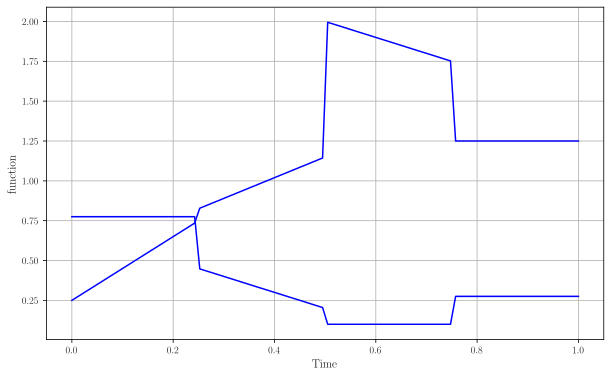

Test for alpha= 0.001 , beta= 0.0001
49 : Active set:
	 0 sigma= [-0.90439382  0.42669874] ,	x_0 = 0.56 ,	type = 1 	weight: 1.5106525083323377 	id: 140128155063296
	 1 sigma= [ 0.99893911 -0.04605048] ,	x_0 = 0.5 ,	type = 0 	weight: 0.6929414095795922 	id: 140128141064768
	 2 sigma= [-0.88514865  0.46530835] ,	x_0 = 0.74 ,	type = 0 	weight: 0.059126926440498766 	id: 140128143273824
	 3 sigma= [ 0.1495819  -0.98874934] ,	x_0 = 0.25 ,	type = 0 	weight: 0.23600713360385353 	id: 140128139257968
	 4 sigma= [0.99162505 0.12915015] ,	x_0 = 0.79 ,	type = 1 	weight: 0.560360065984144 	id: 140128140311104
	 5 sigma= [-0.99999916  0.00129234] ,	x_0 = 0.75 ,	type = 0 	weight: 0.32197291182108795 	id: 140128139262528
	 6 sigma= [-0.43545193  0.90021198] ,	x_0 = 0.75 ,	type = 0 	weight: 0.14147229679381976 	id: 140128141000096
	 7 sigma= [-0.46686632 -0.8843279 ] ,	x_0 = 0.22 ,	type = 1 	weight: 1.0300135633884469 	id: 140128140822912
	 8 sigma= [-0.98335948  0.18167037] ,	x_0 = 0.51 ,	type = 1 	wei

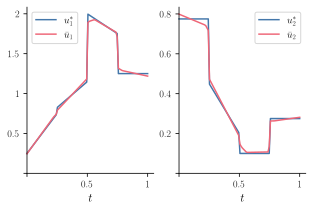

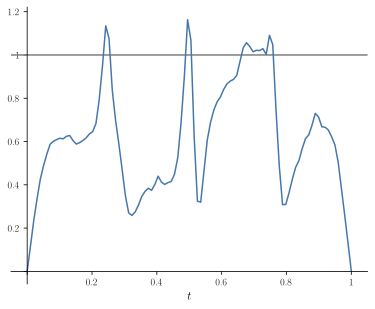

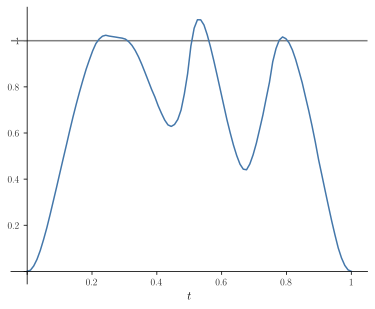

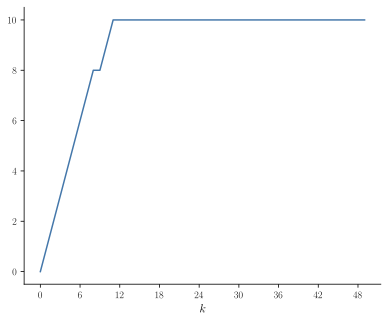

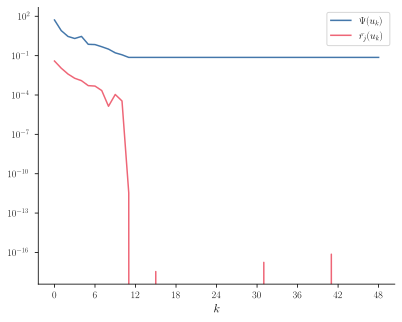

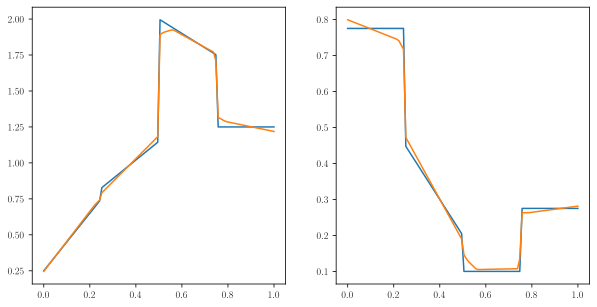

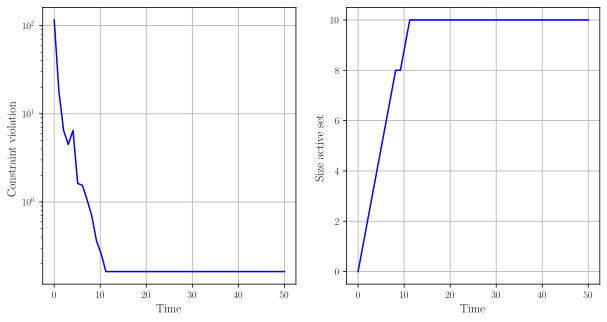

In [5]:
def testRegularizationParameters(alpha, beta, params, originalSignal):
    params.alpha = alpha
    params.beta = beta
    print('Test for alpha=', alpha, ', beta=', beta)
    active_set = []
    weights = np.ones(len(active_set))
    slope = np.ones(params.d)
    y_shift = np.ones(params.d)
    f_0 = 0.5 * calculateL2InnerProduct(params.yd, params.yd, params) 
    active_set, weights, slope, y_shift, constraintViolation, sizeActiveSet, p, P, objectiveValues = algorithm(active_set, weights, slope, y_shift, params)
    norm_p = np.linalg.norm(p, axis=1)/params.alpha
    norm_P = np.linalg.norm(P, axis=1)/params.beta
    printIterationInfo(0, active_set, weights, slope, y_shift, np.identity(1))
    timePoints = np.linspace(0, params.T, num=int(params.T/params.dt))
    u_fin = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)
    reconstruction = np.array([u_fin(t) for t in timePoints])
    
    plot_reconstruction(originalSignal, reconstruction, saveAsSVG=True)
    plot_duals(norm_p, 'p', saveAsSVG=True)
    plot_duals(norm_P, 'P', saveAsSVG=True)
    plot_activeSet(sizeActiveSet, saveAsSVG=True)
    plot_convergence(constraintViolation[:-1] * f_0, objectiveValues[:-1] - np.ones_like(objectiveValues[:-1]) * (objectiveValues[-1]), saveAsSVG=True)
    fig, (ax1, ax2) = mpl.pyplot.subplots(1, 2, figsize=(10, 5))
    
    ax1.plot(timePoints, originalSignal[:, 0], label='u(t)')
    ax1.plot(timePoints, reconstruction[:, 0], label='$\tilde{u}(t)$')
    ax2.plot(timePoints, originalSignal[:, 1], label='u(t)')
    ax2.plot(timePoints, reconstruction[:, 1], label='$\tilde{u}(t)$')
    mpl.pyplot.show()
    fig, (ax3, ax4) = mpl.pyplot.subplots(1, 2, figsize=(10, 5))
    plot_array(constraintViolation, T=len(constraintViolation), label='Constraint violation', ax=ax3)
    ax3.set_yscale('log')
    plot_array(sizeActiveSet, T=len(sizeActiveSet), label='Size active set', ax=ax4)
    mpl.pyplot.show()

params.maxIterations = 50
params.newton_c = 1
params.maxNewtonSteps = 50
params.pruneThreshold = 0
params.verbose = False
params.mollify_const = 0.1
params.solver = computeSSNStepWalter

s1 = lambda t: (2*t+0.25 if t < 0.25 else(1.3*t + 0.5 if t < 0.5 else (-t+2.5 if t < 0.75 else 1.25)))
s2 = lambda t : (0.775 if t <= 0.25 else (0.7 - t if t <= 0.5 else (0.1 if t <= 0.75 else 0.275)))
activeSet = [ExtremalPoint(np.array([ 0.27733291, -0.96077388]), 0.25, type=ExtremalPoint.e_type.JUMP, params=params),
             ExtremalPoint(np.array([1, 0]), 0.5, type=ExtremalPoint.e_type.JUMP, params=params),
             ExtremalPoint(np.array([-0.96851383,  0.24895978]), 0.75, type=ExtremalPoint.e_type.JUMP, params=params),
             ExtremalPoint(np.array([-0.45158029, -0.89223049]), 0.25, type=ExtremalPoint.e_type.KINK, params=params),
             ExtremalPoint(np.array([-0.90315916,  0.42930587]), 0.50, type=ExtremalPoint.e_type.KINK, params=params),
             ExtremalPoint(np.array([0.70391054, 0.71028864]), 0.75, type=ExtremalPoint.e_type.KINK, params=params),
             ExtremalPoint(np.array([ 0.87632461, -0.48172105]), 0.75, type=ExtremalPoint.e_type.KINK, params=params)]

weights = np.array([0.34, 0.8, 0.52, 1.34, 2.67, 0.73, 0.8])
slope = np.array([0.1, -0.2])
y_shift = np.array([0.4, 0.2])
#s1 = lambda t: buildIterationFunction(t, activeSet, weights, slope, y_shift, params)[0]
#s2 = lambda t: buildIterationFunction(t, activeSet, weights, slope, y_shift, params)[1]
setupObservation(s1, s2, params)
g1 = getSourceTerm(params.x1, params)
g2 = getSourceTerm(params.x2, params)
timePoints = np.linspace(0, params.T, num=int(params.T/params.dt))
array = np.ndarray((int(params.T/params.dt), 2))
array[:, 0] = np.array([s1(t) for t in timePoints])
array[:, 1] = np.array([s2(t) for t in timePoints])
plot_array(array, params.T)
#hesse = HesseMatrix(activeSet, params)
#j_bar = computeObjective(weights, activeSet, hesse.standard_states, hesse, params, hesse.standardInner)
testRegularizationParameters(1e-3, 1e-4, params, array)
#testRegularizationParameters(1e-8, 1e-6, params, array)
#testRegularizationParameters(5e-8, 1e-8, params, array)